In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
import adam_custom as adam

In [3]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## On 2D dataset

In [4]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

In [5]:
x1min, x1max, nx1 = -5, 6, 75
x2min, x2max, nx2 = -3, 7, 75
x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
X1, X2 = np.meshgrid(x1, x2)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
    return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

Y = np.zeros(X1.shape)
for p in gprms:
    Y += gaussian(X1, X2, *p)

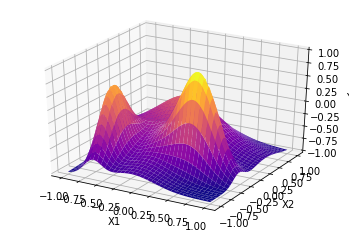

In [6]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [7]:
xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

## Building 2D model

In [8]:
class DynamicLocalResidual(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.old_layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
        self.old_activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.old_layer1 = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.new_layer0 = None
        self.new_activ = None
        self.new_layer1 = None
        
        self.old_params = list(self.old_layer0.parameters())+\
                            list(self.old_activ.parameters())+\
                            list(self.old_layer1.parameters())
        self.new_params = []
        self.optimizer_state = {}
        
    def forward(self, x):
        xo = self.old_layer0(x)
        xo = self.old_activ(xo)
        xo = self.old_layer1(xo)
        if self.new_layer0 is not None:
            xn = self.new_layer0(x)
            xn = self.new_activ(xn)
            xn = self.new_layer1(xn)
            xo = xo + xn
        return xo
    
    def add_new_neurons(self, hidden_dim):
        d = self.old_activ.beta.device
        
        self.new_hidden_dim = hidden_dim
        self.new_layer0 = dtnn.iStereographicLinearTransform(self.input_dim, hidden_dim).to(d)
        self.new_activ = dtnn.OneActiv(hidden_dim, mode='exp_1.6').to(d)
        self.new_layer1 = nn.Linear(hidden_dim, self.output_dim, bias=False).to(d)
        self.new_layer1.weight.data *= 0.01
        
        self.new_params = list(self.new_layer0.parameters())+\
                            list(self.new_activ.parameters())+\
                            list(self.new_layer1.parameters())
        return
    
    def merge_old_new_neurons(self, old_optim, new_optim):
        assert self.new_hidden_dim > 0, "New hidden layer must be > 0"
        d = self.old_activ.beta.device
        
        ### merge all the parameters
        new_w0 = torch.cat([self.old_layer0.linear.weight.data,
                           self.new_layer0.linear.weight.data], dim=0)
        new_b0 = torch.cat([self.old_layer0.linear.bias.data,
                           self.new_layer0.linear.bias.data], dim=0)
        
        new_beta = torch.cat([self.old_activ.beta.data,
                           self.new_activ.beta.data], dim=1)
        
        new_w1 = torch.cat([self.old_layer1.weight.data,
                           self.new_layer1.weight.data], dim=1)
        new_b1 = self.old_layer1.bias.data
        
        ### cat the states as well
        if old_optim is not None and new_optim is not None:
            ### proceed here
            state_old_w0 = old_optim.state[self.old_layer0.linear.weight]
            state_old_b0 = old_optim.state[self.old_layer0.linear.bias]
            state_old_beta = old_optim.state[self.old_activ.beta]
            state_old_w1 = old_optim.state[self.old_layer1.weight]
            state_old_b1 = old_optim.state[self.old_layer1.bias]

            state_new_w0 = new_optim.state[self.new_layer0.linear.weight]
            state_new_b0 = new_optim.state[self.new_layer0.linear.bias]
            state_new_beta = new_optim.state[self.new_activ.beta]
            state_new_w1 = new_optim.state[self.new_layer1.weight]
                        
        return
            
        
        
        self.old_layer0.linear.weight.data = new_w0
        self.old_layer0.linear.bias.data = new_b0
        self.old_activ.beta.data = new_beta
        self.old_layer1.weight.data = new_w1
        self.old_layer1.bias.data = new_b1
        
        self.hidden_dim += self.new_hidden_dim
        self.new_hidden_dim = 0
        
        return

In [9]:
dlr = DynamicLocalResidual(2, 4, 2).to(device)

In [10]:
dlr.add_new_neurons(1)

In [11]:
# dlr.merge_old_new_neurons()

In [12]:
# dlr.

In [13]:
class IRNAS_MLP(nn.Module):
    
    def __init__(self, optimizer_class=torch.optim.Adam):
        super().__init__()
        self.ir0 = DynamicLocalResidual(2, 5, 2)
        self.linear = nn.Linear(2,1)
        
        self.optimizer_class = optimizer_class
        self.old_optimizer = None
        self.new_optimizer = None
        
        ## list of old and new params
        self.old_params = self.ir0.old_params + list(self.linear.parameters())
        self.new_params = []
        self.optimizer_state = {}
        
    def forward(self, x):
        x = x+self.ir0(x)
        x = self.linear(x)
        return x
    
    def get_old_optimizer(self, lr):
        self.old_optimizer = self.optimizer_class(self.old_params, lr=0.0031)
        return self.old_optimizer
    
    def get_old_optimizer(self, lr):
        if len(self.new_params) == 0:
            raise ValueError("No new parameters")
        self.new_optimizer = self.optimizer_class(self.new_params, lr=0.0031)
        return self.new_optimizer
    
    def add_new_neurons(self, hidden_dim):
        assert hidden_dim > 0, "Hidden dim must be greater than 0"
        self.ir0.add_new_neurons(hidden_dim)
        self.new_params = self.ir0.new_params
        return
    
    def merge_old_new_neurons(self):
        ### merge old and new neurons + merge the optimizer
        pass

In [14]:
net = IRNAS_MLP().to(device)

In [15]:
yout = net.forward(xx)
xx.shape, yout.shape

(torch.Size([5625, 2]), torch.Size([5625, 1]))

In [16]:
yout.data

tensor([[ 0.7436],
        [ 0.7324],
        [ 0.7212],
        ...,
        [-0.9127],
        [-0.9262],
        [-0.9396]])

In [17]:
# optimizer = torch.optim.Adam(net.old_params, lr=0.0031)
optimizer = adam.Adam(net.old_params, lr=0.0031)
criterion = nn.MSELoss()

In [24]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

for epoch in range(5000):

    yout = net(xx)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)

0 Error =  0.02014837972819805
200 Error =  0.020130639895796776
400 Error =  0.020117416977882385
600 Error =  0.020110629498958588
800 Error =  0.02010195516049862
1000 Error =  0.020098477602005005
1200 Error =  0.02009645663201809
1400 Error =  0.02009558118879795
1600 Error =  0.020095273852348328


TclError: invalid command name "."

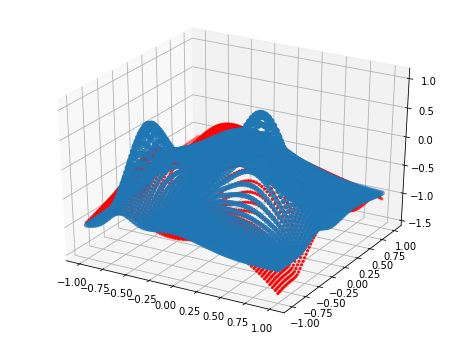

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

In [20]:
state = optimizer.state[net.ir0.old_layer0.linear.weight]
state

{'exp_avg': tensor([[ 1.0418e-05, -2.1507e-05,  9.0504e-06],
         [-2.2689e-06, -3.2908e-07, -1.6316e-05],
         [-4.1750e-06,  4.5548e-06, -1.9482e-05],
         [-7.8157e-06, -1.2969e-05, -2.1065e-05],
         [ 4.5380e-07, -4.8638e-07, -8.4247e-06]]),
 'exp_avg_sq': tensor([[7.3347e-07, 1.5861e-06, 4.2295e-07],
         [7.4100e-07, 6.2896e-07, 5.6930e-07],
         [6.3529e-07, 2.4198e-07, 1.2079e-06],
         [5.1717e-07, 5.6302e-07, 6.2598e-07],
         [1.5878e-07, 1.4104e-07, 4.8649e-07]]),
 'step': tensor([3201])}

In [22]:
state['step'] = torch.ones(5, 1)*state['step']

In [23]:
state

{'exp_avg': tensor([[ 1.0418e-05, -2.1507e-05,  9.0504e-06],
         [-2.2689e-06, -3.2908e-07, -1.6316e-05],
         [-4.1750e-06,  4.5548e-06, -1.9482e-05],
         [-7.8157e-06, -1.2969e-05, -2.1065e-05],
         [ 4.5380e-07, -4.8638e-07, -8.4247e-06]]),
 'exp_avg_sq': tensor([[7.3347e-07, 1.5861e-06, 4.2295e-07],
         [7.4100e-07, 6.2896e-07, 5.6930e-07],
         [6.3529e-07, 2.4198e-07, 1.2079e-06],
         [5.1717e-07, 5.6302e-07, 6.2598e-07],
         [1.5878e-07, 1.4104e-07, 4.8649e-07]]),
 'step': tensor([[3201.],
         [3201.],
         [3201.],
         [3201.],
         [3201.]])}

In [ ]:
net.add_new_neurons(3)

In [ ]:
new_optimizer = torch.optim.Adam(net.new_params, lr=0.0031)
# new_optimizer = torch.optim.Adam(net.parameters(), lr=0.0031)

In [ ]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

for epoch in range(5000):

    yout = net(xx)
    loss = criterion(yout, yy)
    
    new_optimizer.zero_grad()
    loss.backward()
    new_optimizer.step()
    
    if epoch%200 == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)

In [ ]:
p = optimizer.param_groups[0]["params"][0]

In [ ]:
optimizer.state

In [ ]:
new_optimizer.param_groups